## North America, February Mean SWE

| SWE Dataset | Date Range | Projection | Spatial Resolution |
| --- | --- | --- | ---|
|GlobSnow vX | 2009-2016 | EASE grid (EPSG:3408) | 25 km |
|Noah MP GDAS | 2009-2017 | WGS84 (EPSG:4326) | 5 km |
|Noah MP ECMWF | 2009-2017 | WGS84 (EPSG:4326) | 5 km |

SWE values below 0.1 mm are removed from each dataset (0.1 mm was used rather than 0 to remove zeros that had rounding errors) along with nodata values and replaced with NaNs.

From [GlobSnow v3.0](https://www.globsnow.info/index.php?page=Snow_Water_Equivalent) ([monthly SWE](doi:10.1594/PANGAEA.911944)), mean SWE across all Februarys from 2009-2016 is first computed. This GlobSnow product comes in a 25 km spatial resolution EASE grid ([EPSG:3408](https://epsg.io/3408)) map projection. The February mean SWE map is then reprojected (nearest neighbor) into WGS 84 ([EPSG:4326](https://epsg.io/4326)) to match the projection of the Noah MP datasets. The map is clipped to the same spatial extent as Noah MP (Longitudes: -169 to -51, Latitudes: 24 to 72), then resampled (nearest neighbor) to the spatial resolution of Noah MP (5 km) to before masking out mountain regions.

Mountain regions, identified as all mountain classes in the Seasonal Mountain Snow Classes product ([Wrzesien et al., 2019](https://doi.org/10.1029/2019WR025350)), are masked out of each dataset. The Seasonal Mountain Snow Classes product is first resampled (using averaging) from its original 1 km spatial resolution to 5 km prior to masking.

Finally, a cumulative distribution curve is computed for each SWE map.

In [1]:
import xarray as xr
import rioxarray
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def cdf(data):
    # compute cdf values for a 1D array of data
    data = data[~np.isnan(data)] # remove any NaN values
    x = np.sort(data) #sort data
    y = 1. * np.arange(len(data)) / (len(data) - 1) #calculate CDF values
    return x, y

In [3]:
def mountain_mask(ds, resampling=5):
    '''Given a dataset (ds), create a mountain mask from the MODIS Mountain Snow Classes map using reproject match.
       Use resampling=0 for nearest neighbor (when 1km mountain mask is coarser spatial resolution than target dataset)
       Use resampling=5 for average (when 1km mountain mask is finer spatial resolution than target dataset)
       More options and details here: https://rasterio.readthedocs.io/en/stable/api/rasterio.enums.html#rasterio.enums.Resampling'''
    
    # open the mountain mask file
    mtnsnow_classes = xr.open_rasterio(base_filepath + 'MODIS_mtnsnow_classes/MODIS_mtnsnow_classes.tif').squeeze()
    
    # Clip to North America to match spatial extent of NoahMP models (Longitudes: -169 to -51, Latitudes: 24 to 72)
    min_lon, max_lon = -169, -51
    min_lat, max_lat = 24, 72
    mtnsnow_classes = mtnsnow_classes.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)
    
    # set values that are 256 (the nodata value) to zero before resampling
    mtnsnow_classes = mtnsnow_classes.where(mtnsnow_classes!=256, 0)
    
    # resample to match target dataset (ds) spatial resolution
    mtnsnow_classes_rpr = mtnsnow_classes.rio.reproject_match(ds, resampling=resampling)
    
    # create the mountain mask by finding all non-zero pixels, these are mountains
    mtn_mask = mtnsnow_classes_rpr.where(mtnsnow_classes_rpr>0).isnull()
    
    return mtn_mask

In [4]:
base_filepath = 'C:/Users/steve/OneDrive/Documents/School Stuff/UW/Mountain Hydrology Research Group/Snow Sensor Usability Paper - Passive Microwave/Data/'

---

### Noah MP GDAS

In [5]:
# read in NoahMP GDAS February mean SWE geotiff
swe_noahmp_gdas_febmean_mm = xr.open_rasterio(base_filepath + 'NoahMP/swe_noahmp_gdas_febmean_mm.tif').squeeze()

# replace nodata values (-1, or anything negative) and zeros with NaNs
swe_noahmp_gdas_febmean_mm = swe_noahmp_gdas_febmean_mm.where(swe_noahmp_gdas_febmean_mm > .1)

# apply the mountain mask
swe_noahmp_gdas_febmean_mm = swe_noahmp_gdas_febmean_mm.where(mountain_mask(swe_noahmp_gdas_febmean_mm))

# compute NoahMP GDAS CDF
gdas_cdf_x, gdas_cdf_y = cdf(swe_noahmp_gdas_febmean_mm.values.ravel())

# convert to a pandas dataframe
gdas_cdf_df = pd.DataFrame(data={'cdf_x': gdas_cdf_x, 'cdf_y': gdas_cdf_y})

# export CDF values to a csv file
gdas_cdf_df.to_csv('swe_noahmp_gdas_febmean_mm_CDF.csv')

### Noah MP ECMWF

In [6]:
# read in NoahMP ECMWF February mean SWE geotiff
swe_noahmp_ecmwf_febmean_mm = xr.open_rasterio(base_filepath + 'NoahMP/swe_noahmp_ecmwf_febmean_mm.tif').squeeze()

# replace nodata values (-1, or anything negative) and zeros with NaNs
swe_noahmp_ecmwf_febmean_mm = swe_noahmp_ecmwf_febmean_mm.where(swe_noahmp_ecmwf_febmean_mm > .1)

# apply the mountain mask
swe_noahmp_ecmwf_febmean_mm = swe_noahmp_ecmwf_febmean_mm.where(mountain_mask(swe_noahmp_ecmwf_febmean_mm))

# compute NoahMP ECMWF CDF
ecmwf_cdf_x, ecmwf_cdf_y = cdf(swe_noahmp_ecmwf_febmean_mm.values.ravel())

# convert to a pandas dataframe
ecmwf_cdf_df = pd.DataFrame(data={'cdf_x': ecmwf_cdf_x, 'cdf_y': ecmwf_cdf_y})

# export CDF values to a csv file
ecmwf_cdf_df.to_csv('swe_noahmp_ecmwf_febmean_mm_CDF.csv')

### GlobSnow

In [7]:
# find GlobSnow SWE NetCDF files for Feb
filepaths = glob.glob(base_filepath + 'GlobSnow/GlobSnow-2009-2016/????02*.nc') # search for filepaths with YYYY02, for February of all years

# open each February GlobSnow SWE map and reproject to WGS84
ds_list = []
for filepath in filepaths:
    ds = xr.open_dataset(filepath)
    ds_swe = ds.swe.rio.set_crs("EPSG:3408").rio.reproject("EPSG:4326") # set crs to EASE grid, then reproject (nearest neighbor) to WGS84
    ds_list.append(ds_swe)
# concat together    
da = xr.concat(ds_list, dim='year')
# take the mean across all years
swe_globsnow_mean_mm = da.mean(axis=0)

# Clip to North America to match spatial extent of NoahMP models (Longitudes: -169 to -51, Latitudes: 24 to 72)
min_lon, max_lon = -169, -51
min_lat, max_lat = 24, 72
swe_globsnow_febmean_mm = swe_globsnow_mean_mm.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)

# replace values <= 0 with Nan
swe_globsnow_febmean_mm = swe_globsnow_febmean_mm.where(swe_globsnow_febmean_mm > .1)

# reproject to NoahMP spatial resolution
swe_globsnow_febmean_mm = swe_globsnow_febmean_mm.rio.reproject_match(swe_noahmp_gdas_febmean_mm, resampling=0) # nearest neighbor

# apply the mountain mask
swe_globsnow_febmean_mm = swe_globsnow_febmean_mm.where(mountain_mask(swe_globsnow_febmean_mm).values)

# compute GlobSnow CDF
globsnow_cdf_x, globsnow_cdf_y = cdf(swe_globsnow_febmean_mm.values.ravel())

# convert to a pandas dataframe
globsnow_cdf_df = pd.DataFrame(data={'cdf_x': globsnow_cdf_x, 'cdf_y': globsnow_cdf_y})

# export CDF values to a csv file
globsnow_cdf_df.to_csv('swe_globsnow_febmean_mm_CDF.csv')

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


---

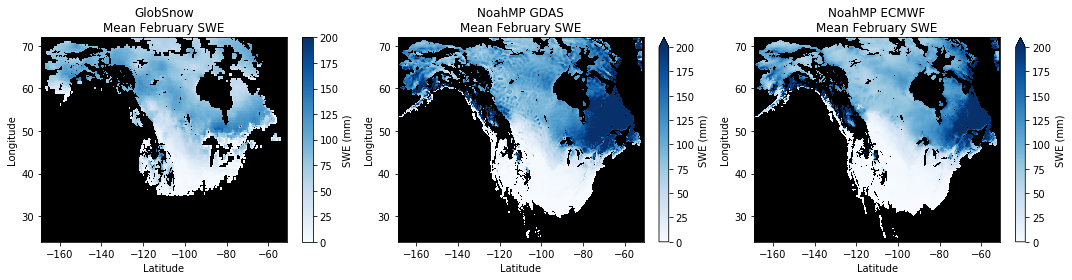

In [8]:
### Map plots ###
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(15,4),tight_layout=True,gridspec_kw={'width_ratios': [1, 1, 1]})
[ax1, ax2, ax3] = ax.ravel()

swe_globsnow_febmean_mm.plot(ax=ax1, vmin=0, vmax=200, cmap='Blues', cbar_kwargs={'label': 'SWE (mm)'})

# NoahMP GDAS map
swe_noahmp_gdas_febmean_mm.plot(ax=ax2, vmin=0, vmax=200, cmap='Blues', cbar_kwargs={'label': 'SWE (mm)'})

# NoahMP ECMWF map
swe_noahmp_ecmwf_febmean_mm.plot(ax=ax3, vmin=0, vmax=200, cmap='Blues', cbar_kwargs={'label': 'SWE (mm)'})

# format map plots
ax1.set_title('GlobSnow\nMean February SWE')
ax2.set_title('NoahMP GDAS\nMean February SWE')
ax3.set_title('NoahMP ECMWF\nMean February SWE')

for this_ax in ax:
    this_ax.set_ylabel('Longitude')
    this_ax.set_xlabel('Latitude')
    this_ax.set_facecolor("black")

# save figure
plt.savefig('northamerica-swe-maps-mountainsmasked.jpg')

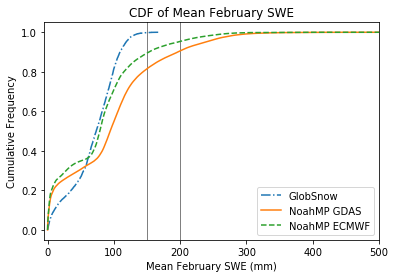

In [9]:
### CDF plot ###
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4),tight_layout=False)

# GlobSnow CDF
ax.plot(globsnow_cdf_x, globsnow_cdf_y, '-.', label='GlobSnow')

# NoahMP GDAS CDF
ax.plot(gdas_cdf_x, gdas_cdf_y, '-', label='NoahMP GDAS')

# NoahMP ECMWF CDF
ax.plot(ecmwf_cdf_x, ecmwf_cdf_y, '--', label='NoahMP ECMWF')

# add vertical lines for max SWE thresholds
ax.axvline(150, c='grey', lw=1, zorder=-99)
ax.axvline(200, c='grey', lw=1, zorder=-99)

# format CDF plot
ax.set_xlim((-5,500))
ax.set_title('CDF of Mean February SWE')
ax.set_ylabel('Cumulative Frequency')
ax.set_xlabel('Mean February SWE (mm)')
ax.legend(loc='lower right');

# save figure
plt.savefig('northamerica-swe-cdfs-mountainsmasked.jpg')